<a href="https://colab.research.google.com/github/Natalia409634/Machine-Learning/blob/main/T2_decisionTreesHyperparameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Estructura de la sesión:
- Ajuste de hiperparámetros en los árboles de decisión
- Combinar el ajuste de hiperparámetros y la evaluación de modelos
  - GridSearch
  - RandomSearch
  - Modificación de hiperparámetros
- Árboles de regresión


# HIPERPARÁMETROS DE LOS ÁRBOLES DE DECISIÓN. AJUSTE DE ÁRBOLES DE DECISIÓN

- **max_depth : int or None, opcional (por defecto=None)**
    La profundidad máxima del árbol. Si es None, los nodos se expanden hasta que todas las hojas sean puras o hasta que todas las hojas contengan menos muestras que min_samples_split. Se ignora si max_leaf_nodes no es None.
    
- **min_samples_split : int, opcional (por defecto=2)**
    El número mínimo de muestras necesarias para dividir un nodo interno.

- Hay más parámetros: 
  - https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
  - https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html



Primero, se cargan los datos, las entradas van a X, las salidas a y.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_boston
from scipy.stats import sem

boston = load_boston()
X = boston.data
y = boston.target

## COMBINAR EL AJUSTE DE HIPERPARÁMETROS Y LA EVALUACIÓN DE MODELOS

La combinación de evaluación de modelos y ajuste de hiperparámetros puede entenderse como un bucle externo (outer) que entrena un modelo y prueba el modelo, y un bucle interno (inner), donde el proceso de entrenamiento consiste en buscar los mejores hiperparámetros, y luego obtener el modelo con esos mejores hiperparámetros.

En primer lugar, vamos a utilizar **Holdout** (entrenar/probar) para la evaluación del modelo (bucle externo o **outer**), y **3-fold crossvalidation** para el ajuste de los hiperparámetros (bucle interno o **inner**). Los hiperparámetros se ajustarán con **Gridsearch**.

#### GRIDSEARCH

En primer lugar, definamos nuestra función python para el RMSE

In [ ]:
def rmse(y_test, y_test_pred):
  """ This is my computation of Root Mean Squared Error """
  return np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

In [ ]:
from sklearn.model_selection import train_test_split

# Holdout for model evaluation. 33% of available data for test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42)

En primer lugar, recordemos el RMSE con hiperparámetros por defecto

In [ ]:
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
#primero vemos los rdos con los valores con defecto, que da 4,3
regr = DecisionTreeRegressor()
np.random.seed(42)
regr.fit(X=X_train, y=y_train)
print(f"RMSE of tree with default hyper-pars: {rmse(y_test, regr.predict(X=X_test))}")
#el error no esta mal pero podria ser mucho mejor para este problema.

RMSE of tree with default hyper-pars: 4.338022949890013


In [ ]:
#para hacer la busqueda de los nuevos parametros: 

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import KFold


# Search space

param_grid = {'max_depth': list(range(2,16,2)),
              'min_samples_split': list(range(2,16,2))}
#bucle interno que busca los parametros-> random state es semillla, siempre es el mismo
inner = KFold(n_splits=3, shuffle=True, random_state=42)

# Definition of a 2-step process that self-adjusts 2 hyperpars
#de regresor utilizao un arbol pero podria ser cualquier otro, el cv es el kfols
regr = GridSearchCV(DecisionTreeRegressor(), 
                   param_grid,
                   scoring='neg_mean_squared_error',
                   cv=inner, 
                   n_jobs=1, verbose=1)

#despues de hacer el modelo hace fit(entrena el modelo)
# Train the self-adjusting process
np.random.seed(42)
regr.fit(X=X_train, y=y_train)

# At this point, regr contains the model with the best hyper-parameters found by gridsearch
# and trained on the complete X_train

Fitting 3 folds for each of 49 candidates, totalling 147 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=1,
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14],
                         'min_samples_split': [2, 4, 6, 8, 10, 12, 14]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
# Now, the performance of regr is computed on the test partition
#el error nuevo es de 3,8-> se ha reducido el error por lo que ha mejorado, los mejores parametros son max depth de 14,...
print(f"RMSE of tree with hyper-parameter tuning (grid-search): {rmse(y_test, regr.predict(X=X_test))}")

RMSE of tree with hyper-parameter tuning (grid-search): 3.8009392110743123


Veamos los mejores hiperparámetros y su puntuación (MSE). Podemos ver que están cerca de los extremos del espacio de parámetros, pero no en el extremo.

In [ ]:
regr.best_params_, -regr.best_score_

({'max_depth': 14, 'min_samples_split': 12}, 23.456921558430547)

#### BUSQUEDA ALEATORIA (RANDOMIZED SEARCH)

Ahora, utilicemos **Búsqueda aleatoria** en lugar de gridsearch. Sólo se probarán 20 combinaciones de valores de hiperparámetros (budget=20)

In [ ]:
#hacemos una busqueda random

from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn import metrics


# Search space
param_grid = {'max_depth': list(range(2,16,2)),
              'min_samples_split': list(range(2,16,2))}

# Inner evaluation
inner = KFold(n_splits=3, shuffle=True, random_state=42)

#aqui creamos un budget-> cuantas muestras aleatorias uso en el randomsearch
budget = 20
regr = RandomizedSearchCV(DecisionTreeRegressor(), 
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner, 
                         n_jobs=1, verbose=1,
                         n_iter=budget
                        
                  
                        )

#misma semilla y aprende
np.random.seed(42)
regr.fit(X=X_train, y=y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=DecisionTreeRegressor(), n_iter=20, n_jobs=1,
                   param_distributions={'max_depth': [2, 4, 6, 8, 10, 12, 14],
                                        'min_samples_split': [2, 4, 6, 8, 10,
                                                              12, 14]},
                   scoring='neg_mean_squared_error', verbose=1)

In [ ]:
# Now, the performance of regr is computed on the test partition

print(f"RMSE of tree with hyper-parameter tuning (random search): {rmse(y_test, regr.predict(X=X_test))}")

RMSE of tree with hyper-parameter tuning (random search): 3.8879277615339674


In [ ]:
regr.best_params_, -regr.best_score_

({'min_samples_split': 12, 'max_depth': 12}, 23.47266047404506)

Para la **Búsqueda Aleatoria**, podemos definir el espacio de búsqueda con distribuciones estadísticas, en lugar de utilizar valores particulares como hacíamos antes. A continuación puedes ver cómo utilizar una distribución uniforme sobre enteros entre 2 y 16 mediante *randint*. Para hiperparámetros continuos podríamos usar distribuciones continuas como *uniform* o *expon* (exponencial).

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn import metrics


from scipy.stats import uniform, expon
from scipy.stats import randint as sp_randint

#de 2 a 16 dame un valor uniformemente aleatorio
# Search space with integer uniform distributions
param_grid = {'max_depth': sp_randint(2,16),
              'min_samples_split': sp_randint(2,16)}

inner = KFold(n_splits=3, shuffle=True, random_state=42)

budget = 20
regr = RandomizedSearchCV(DecisionTreeRegressor(), 
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner, 
                         n_jobs=1, verbose=1,
                         n_iter=budget
                        )

np.random.seed(42)
regr.fit(X=X_train, y=y_train)

# At this point, regr contains the model with the best hyper-parameters found by gridsearch
# and trained on the complete X_train

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=DecisionTreeRegressor(), n_iter=20, n_jobs=1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff986189e50>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff986189550>},
                   scoring='neg_mean_squared_error', verbose=1)

In [ ]:
# Now, the performance of regr is computed on the test partition
#se ha bajado un poco el error
print(f"RMSE of tree with hyper-parameter tuning (random search II): {rmse(y_test, regr.predict(X=X_test))}")

RMSE of tree with hyper-parameter tuning (random search II): 3.879204914028741


In [ ]:
regr.best_params_, -regr.best_score_

({'max_depth': 14, 'min_samples_split': 12}, 23.466854735241096)

¿Y si quisiéramos hacer **evaluación de modelos con 5-fold crossvalidation** y **ajuste de hiperparámetros con 3-fold crossvalidation**? Esto se denomina validación cruzada anidada https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html). Hay un bucle externo (para evaluar los modelos) y un bucle interno (para ajustar los hiperparámetros)

In [ ]:
#

from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn import metrics

# random_state=42 for reproducibility
# Evaluation of model (outer loop)
outer = KFold(n_splits=5, shuffle=True, random_state=42)


from scipy.stats import uniform, expon

# Search space
param_grid = {'max_depth': list(range(2,16,2)),
              'min_samples_split': list(range(2,16,2))}

inner = KFold(n_splits=3, shuffle=True, random_state=42)

budget = 20
# This is the internal 3-fold crossvalidation for hyper-parameter tuning
regr = RandomizedSearchCV(DecisionTreeRegressor(), 
                         param_grid,
                         scoring='neg_mean_squared_error',
                         # 3-fold for hyper-parameter tuning
                         cv=inner, 
                         n_jobs=1, verbose=1,
                         n_iter=budget
                        )

# This is the external 5-fold crossvalidation for model evaluation
# Notice that regr is the model resulting of hyper-parameter tuning
np.random.seed(42)

# For sklearn, higher scores are better. Given that MSE is an error (smaller is better), the corresponding score is -MSE
scores = -cross_val_score(regr, 
                            X, y, 
                            scoring='neg_mean_squared_error', 
                            cv = outer)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [ ]:
print(scores)
# The score was MSE, we want RMSE
scores = np.sqrt(scores)
# The mean of the 5-fold crossvalidation is the final score of the model
print(f"{scores.mean()} +- {scores.std()}")

[ 8.57097787 13.91342812 39.52647818 20.14700622 21.3531072 ]
4.410837324219566 +- 1.1165633060314761


#### OBTENCIÓN DEL MODELO FINAL (PARA SU DESPLIEGUE, O PARA ENVIARLO A UN CONCURSO, ...)

Si necesitamos un modelo final, podemos obtenerlo ajustando regr a todos los datos disponibles. Recordemos que regr hace ajuste de hiper-parámetros.

In [ ]:
np.random.seed(42)

# Fitting again the randomized search HPO
regrFinal = regr.fit(X,y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [ ]:
regr.best_params_, -regr.best_score_

({'min_samples_split': 8, 'max_depth': 6}, 19.699003696570447)

### OPTIMIZACIÓN BASADA EN MODELOS (BAYESIAN OPTIMIZATION)

Para ello se utilizará scikit-optimize (skopt): https://scikit-optimize.github.io. **Holdout** para la evaluación del modelo y **3-fold crossvalidation** para el ajuste de hiperparámetros (con **Model Based Optimization** ).

In [ ]:
# !pip install scikit-learn==0.24.2
# !pip install scikit-optimize
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/scikit-optimize/scikit-optimize.git to /tmp/pip-req-build-o9nulyyf
  Running command git clone --filter=blob:none --quiet https://github.com/scikit-optimize/scikit-optimize.git /tmp/pip-req-build-o9nulyyf
  Resolved https://github.com/scikit-optimize/scikit-optimize.git to commit a2369ddbc332d16d8ff173b12404b03fea472492
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pyaml-21.10.1-py2.py3-none-any.whl (24 kB)
  Created wheel for scikit-optimize: filename=scikit_optimize-0.9.0-py2.py3-none-any.whl size=100268 sha256=cc56418f9d1f437412e8293904fd6579619e9a6a5e5d1f68940ea0ac387e67c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-ek92z3rx/wheels/40/48/e7/8f8bf2b4c2c847051cfaac9d3603002e5109468805dcc72b3a
Successfully built scikit-optimize


In [ ]:
# Checking that everything is correct with skopt (0.9.dev0) and sklearn 
from skopt import __version__
print(__version__)
from sklearn import __version__
print(__version__)

0.9.0
1.0.2


In [ ]:
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from sklearn import metrics
from skopt.plots import plot_objective, plot_histogram, plot_convergence
from sklearn.model_selection import KFold

# Search space with integer uniform distributions
param_grid = {'max_depth': Integer(2,16),
              'min_samples_split': Integer(2,16)}

inner = KFold(n_splits=3, shuffle=True, random_state=42)
budget = 20
regr = BayesSearchCV(DecisionTreeRegressor(), 
                    param_grid,
                    scoring='neg_mean_squared_error',
                    cv=inner,    
                    n_jobs=1, verbose=1,
                    n_iter=budget
                    )
np.random.seed(42)
regr.fit(X=X_train, y=y_train)

# At this point, regr contains the model with the best hyper-parameters found by bayessearch
# and trained on the complete X_train

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.8/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.8/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.8/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.8/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


BayesSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
              estimator=DecisionTreeRegressor(), n_iter=20,
              scoring='neg_mean_squared_error',
              search_spaces={'max_depth': Integer(low=2, high=16, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=16, prior='uniform', transform='normalize')},
              verbose=1)

In [ ]:
# Now, the performance of regr is computed on the test partition

print(f"RMSE of tree with hyper-parameter tuning (bayesian optimization): {rmse(y_test, regr.predict(X=X_test))}")

RMSE of tree with hyper-parameter tuning (bayesian optimization): 3.9557488945335764


In [ ]:
regr.best_params_, -regr.best_score_

(OrderedDict([('max_depth', 14), ('min_samples_split', 11)]),
 23.470621822368187)

Podemos comprobar si la optimización ha convergido

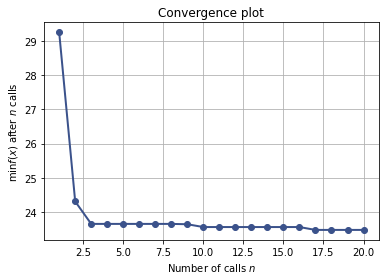

In [ ]:
_ = plot_convergence(regr.optimizer_results_[0])
plt.show()

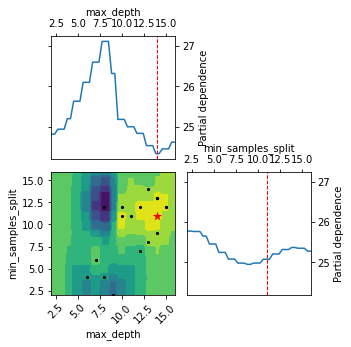

In [ ]:
_ = plot_objective(regr.optimizer_results_[0],
                   dimensions=['max_depth', 'min_samples_split'],
                   n_minimum_search=int(1e8))
plt.show()